# VIX Raw data import from CBOE
We have three sources of data: TSM, CBOE and Cheng spreadsheet

In [49]:
from IPython.display import display_html, HTML
import pyfolio as pf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import zipfile
import os
import re
from time import time
import feather
from pathlib import Path

import sys
opt_path = '/Users/ebellord/PycharmProjects/opt_trade'
if  opt_path not in sys.path:
    sys.path.append(opt_path)
from ftplib import FTP
from spx_data_update import data_shop_login, UpdateSP500Data, VixTSM, SP500Index, CBOEIndex, ImpliedVolatilityHistory
from option_utilities import read_feather, perf_stats
from vix_utilities import VixCBOE
from implied_to_realized import SPX5MinuteBars


# Data Comparison
- There are two sources of data (TSM & CBOE) as well as the spreadsheet data from the Vix Premium paper.
- TSM contract dates and CBOE contract dates are significantly missmatched. TSM contract dates are last day of trading while CBOE dates are actual expiries. In addition TSM contract dates sometimes roll on different dates.

In [44]:
vix_tsm = VixTSM()
sp5 = SP500Index(update=False)
cboe = CBOEIndex()
iv_hist = ImpliedVolatilityHistory()
vix = iv_hist.implied_vol_index


vixp_d, vixp_m = [pd.read_excel(UpdateSP500Data.DATA_BASE_PATH / 'xl' / 'VIX_Premium.xlsx', 
                           sheet_name=sheet_name) for sheet_name in ['Daily', 'Monthly']]
vixp_d['dt'], vixp_m['dt'] = [df['dt'].apply(pd.to_datetime) for df in [vixp_d, vixp_m]]
vixp_d, vixp_m = [df.set_index('dt') for df in [vixp_d, vixp_m]]
vixp_d.index.name, vixp_m.index.name = [None for df in [vixp_d, vixp_m]] 
vixp_contract_dates = vixp_d['contract_dt']

vix_cboe = VixCBOE()
bars = SPX5MinuteBars(update_bars=False)

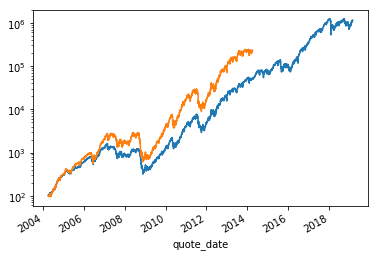

In [10]:
perf_stats(vix_cboe.rolled_return_short.dropna())
vix_cboe.rolled_idx_short.plot(logy=True)
vix_tsm.rolled_idx_short.plot(logy=True)

In [ ]:
display(pd.concat([perf_stats(vix_cboe.rolled_idx_short.reindex(vix_tsm.rolled_idx_short.index).pct_change().dropna()), 
           perf_stats(vix_tsm.rolled_return_short),
           perf_stats(vix_cboe.rolled_return_short)], axis=1))

In [53]:
vix_cboe.rolled_idx
def table1_stats(df, name, mult=1):
    out_series = df.describe().copy()
    out_series[1:] = out_series[1:] * mult
    out_series['First'], out_series['Last'] = [df.index[item].strftime('%b-%y') for item in [0, -1]]
    out_series = out_series.reindex(['count', 'First', 'Last', 'mean', 'std', 'min',
                                    'max', '50%'])
    return out_series.rename(name)

realized_vol = np.sqrt(bars.realized_variance * 12)
vix_ret_monthly_col = vix_cboe.rolled_idx.resample('BM', closed='left').ffill().pct_change().dropna(how='any')

table1 = pd.concat([table1_stats(vix['03-2004':'11-2015'].resample('BM', closed='left').ffill().dropna(how='any'),
                                 'CBOE Volatility Index (VIX)'),
                    table1_stats(vix_cboe.rolled_future()[-1]['02-2004':'11-2015'].resample('BM', closed='left').ffill().dropna(how='any'),
                                 'VIX Futures'),
                    table1_stats(vix_ret_monthly_col, 'VIX Futures return', 100),
                    table1_stats(vixp_m['vixp_2004'].dropna(how='any'), 'VIXP'),
                    table1_stats(vixp_m['vixr_2004'].dropna(how='any'), 'VIXR', 100),
                    table1_stats(realized_vol['02-2004':'11-2015'].resample('BM', closed='left').ffill().dropna(how='any'),
                                 'Realized Volatility', 100),
                    table1_stats(cboe.skew['03-2004':'11-2015'].resample('BM', closed='left').ffill().dropna(how='any'),
                               'CBOE SKEW Index'),
                    table1_stats(cboe.vvix['03-2004':'11-2015'].resample('BM', closed='left').ffill().dropna(how='any'),
                               'CBOE VVIX Index'),
                    table1_stats(sp5.return_index['03-2004':'11-2015'].resample('BM', closed='left').ffill().pct_change().dropna(how='any'),
                                'S&P 500 Excess', 100)], axis=1)

display(table1.transpose().style.set_caption('Table1. Monthly Summary Statistics').format({'mean': '{:,.3f}', 'std': '{:,.3f}', 'min': '{:,.2f}',
                                    'max': '{:,.3f}', '50%': '{:,.3f}'}))


,count,First,Last,mean,std,min,max,50%
CBOE Volatility Index (VIX),141,Mar-04,Nov-15,19.573,8.757,10.42,59.890,16.740
VIX Futures,140,Apr-04,Nov-15,19.937,8.250,11.31,54.570,16.850
VIX Futures return,178,May-04,Feb-19,-3.839,16.730,-30.03,93.442,-6.953
VIXP,140,Mar-04,Oct-15,0.706,1.415,-4.62,4.197,0.444
VIXR,140,Mar-04,Oct-15,-2.511,5.670,-14.03,10.014,-2.393
Realized Volatility,140,Apr-04,Nov-15,15.620,10.388,6.04,80.857,11.826
CBOE SKEW Index,141,Mar-04,Nov-15,120.182,5.842,106.43,139.350,120.130
CBOE VVIX Index,107,Jan-07,Nov-15,86.781,12.528,64.49,127.280,86.080
S&P 500 Excess,140,Apr-04,Nov-15,0.698,4.108,-16.80,10.929,1.291


In [ ]:

# class VixReturn:
#     def __init__(self, expiry_type=0):
#         """ Class to retrieve CBOE vix futures data and create return and index series"""
#         " add check for 2 expiry columns and two price columns"

#         vix_cboe = read_feather(UpdateVIXData.DIRECTORY / 'feather' / 'vix_data.feather')
#         vix_cboe = vix_cboe.set_index('quote_date')

#         # Fill missing close price with average of bid & ask
#         matching_exp = [s for s in vix_cboe.columns if "expiry" in s]
#         close_digits = []
#         for string in matching_exp:
#             digit = int(re.findall("\d+", string)[0])
#             close_digits.append(digit)

#         close_digits.sort()
#         for item in close_digits:
#             vix_cboe.loc[:, 'close' + str(item)] = vix_cboe[['close_ask' + str(item),
#                                                              'close_bid' + str(item)]].mean(axis=1)
#             vix_cboe.loc[:, 'close' + str(item)] = vix_cboe.loc[:, 'close' + str(item)].fillna(vix_cboe.loc[:, 'close_px' 
#                                                                                                            + str(item)])
#         self.closing_prices = vix_cboe[['close' + str(digit) for digit in close_digits]]
#         self.expirations = vix_cboe[['expiry' + str(digit) for digit in close_digits]]
       
#         self.start_date = self.closing_prices.index[0]
#         self.expiry_type = expiry_type  # expiry_type is either string or positive integer
    
#     @property
#     def expiry_returns(self):
#         """ Returns continous future arithmetic return if contracts are held to expiry"""
#         roll_rows = self.expirations['expiry1'].diff(1) > pd.Timedelta('0 Days') # Day before expiry
#         returns = self.closing_prices.pct_change()
#         close = self.closing_prices.copy()
#         # Cross the columns on the day after expiry
#         column_shift_ret = close.divide(close.shift(periods=-1, axis='columns').shift(periods=1, axis='rows')) - 1
#         returns[roll_rows] = column_shift_ret[roll_rows]
#         return returns
    
#     @property
#     def expiration_days_2_expiry(self):
#         expirations = self.expirations.copy()
#         column_names = self.expirations.columns
#         busday_list = []
#         _notNaT = np.datetime64(pd.datetime.today())
#         for col in column_names:
#             expiry = expirations[col]
#             begin_dates = expiry.index
#             end_dates = pd.DatetimeIndex(expiry.values)
#             endmask = end_dates.to_series().isna().values
#             bus_days = np.busday_count(list(begin_dates.date), list(pd.DatetimeIndex(np.where(endmask, _notNaT, end_dates)).date))
#             out_bus_days = [np.nan if x in bus_days[endmask] else x for x in bus_days]
#             busday_list.append(pd.Series(data=out_bus_days, index=expiry.index, name=col))
#         return pd.concat(busday_list, axis=1)
    

#     def rolled_future_return(self):
#         expiry_dates = self.expirations['expiry1']
#         returns = self.expiry_returns
#         days_2_exp = self.expiration_days_2_expiry
#         eom_dates = returns.loc[returns.groupby(returns.index.to_period('M')).apply(lambda x: x.index.max())].index

#         last_month_end = eom_dates[-1] + pd.offsets.MonthEnd(0)
#         eom_dates = eom_dates[:-1]
#         eom_dates = eom_dates.insert(-1, last_month_end)
#         roll_dates = eom_dates.sort_values()

#         expiry_for_roll = []
#         for dts in expiry_dates:
#             idx = roll_dates.get_loc(dts, method='ffill')
#             expiry_for_roll.append(roll_dates[idx])
#         day_diff = expiry_dates.index - pd.DatetimeIndex(expiry_for_roll)
#         front_month_bool = day_diff.days <= 0
#         back_month_bool = ~front_month_bool

#         rolled_return = pd.concat([returns['close2'][back_month_bool], returns['close1'][front_month_bool]],
#                                   axis=0).sort_index()
#         rolled_return[0] = np.nan  # replace first empty observation with NaN

#         rolled_expiries = pd.concat([self.expirations['expiry2'][back_month_bool],
#                                      self.expirations['expiry1'][front_month_bool]], axis=0).sort_index()

#         days_2_exp = pd.concat([days_2_exp['expiry2'][back_month_bool],
#                                 days_2_exp['expiry1'][front_month_bool]], axis=0).sort_index()

#         rolled_future = pd.concat([self.closing_prices['close2'][back_month_bool],
#                                    self.closing_prices['close1'][front_month_bool]], axis=0).sort_index()

#         return rolled_return, rolled_expiries, days_2_exp, rolled_future

In [ ]:
UpdateVIXData.DIRECTORY